# Data 100 Final Project #

#### Authors: Abhishek Roy, Gayatri Babel, Suyash Jaju

#### Assignment: Final Project for Spring 2020

#### Class: Data 100 – Principles and Techniques of Data Science

#### Department: Data Science

In [117]:
import numpy as np
import pandas as pd
import math

# Graphing tools
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Modelling tools
from sklearn import model_selection, linear_model as lm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [118]:
counties = pd.read_csv('abridged_couties.csv')
states = pd.read_csv('4.18states.csv')
covid_c = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',index_col=0)
covid_d = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv',index_col=0)

## Questions We Will Be Addressing

We decided to break the problem we are trying to solve by analyzing our data across two main levels: 

1) County-level

2) State-level

We decided to restrict our scope to California and its counties. Following are some questions we sought to address.

***State-level:***
- What features can be utilized to measure the risk posed by the pandemic in different counties?
- How can this methodology help with grouping counties into three main risk levels?


***County-level***
- What kind of model will result in the best accuracy to predict new COVID-19 cases and deaths for a given county?
- How can we build an adaptable model that can be applied to other counties to determine the level of risk associated with restarting the local economy?

## Useful Functions

In [119]:
def get_data(df,county_col):
    melt = pd.melt(df,id_vars=[county_col], value_vars= covid_d.columns.values[11:])
    melt = melt.rename(columns={county_col:'CountyName', 'variable':'Date'})
    melt['Date'] = pd.to_datetime(melt['Date'])
    return melt

def check_multiple_readings(df):
    multiples = []
    for name in df['CountyName'].unique():
        df1 = df[df['CountyName'] == name]
        if len(df1) > 88:
            multiples.append(name)
    return multiples

## Data Cleaning and Preliminary Analysis

### States Data Set

In [120]:
print(states.shape)
states.head()

(140, 18)


Province_State Country_Region          Last_Update      Lat     Long_  \
0         Alabama             US  2020-04-18 22:32:47  32.3182  -86.9023   
1          Alaska             US  2020-04-18 22:32:47  61.3707 -152.4044   
2  American Samoa             US                  NaN -14.2710 -170.1320   
3         Arizona             US  2020-04-18 22:32:47  33.7298 -111.4312   
4        Arkansas             US  2020-04-18 22:32:47  34.9697  -92.3731   

   Confirmed  Deaths  Recovered  Active  FIPS  Incident_Rate  People_Tested  \
0       4712     153        NaN  4559.0   1.0     100.492717        42538.0   
1        314       9      147.0   305.0   2.0      52.530410         9655.0   
2          0       0        NaN     NaN  60.0       0.000000            3.0   
3       4724     180      539.0  4544.0   4.0      64.901548        51045.0   
4       1744      38      703.0  1706.0   5.0      67.361213        24141.0   

   People_Hospitalized  Mortality_Rate       UID ISO3  Testing_Rate  \
0                620.0        3.247029  84000001  USA    907.206961   
1                 39.0        2.866242  84000002  USA   1615.226458   
2                  NaN             NaN        16  ASM      5.391708   
3                566.0        3.810330  84000004  USA    701.291175   
4                291.0        2.178899  84000005  USA    932.435235   

   Hospitalization_Rate  
0             13.157895  
1             12.420382  
2                   NaN  
3             11.981372  
4             16.685780

In [121]:
states = states[(states['Lat'].isnull() == False) & (states['Long_'].isnull() == False)]

In [122]:
US_States = states[(states['Country_Region'] == 'US')]
US_States.isnull().sum()

Province_State           0
Country_Region           0
Last_Update              1
Lat                      0
Long_                    0
Confirmed                0
Deaths                   0
Recovered               24
Active                   1
FIPS                     0
Incident_Rate            0
People_Tested            0
People_Hospitalized      7
Mortality_Rate           1
UID                      0
ISO3                     0
Testing_Rate             0
Hospitalization_Rate     7
dtype: int64

We can see that most of the data points for the US are complete. Only a few NaN values which we will be filling. 

In [123]:
US_States = US_States.fillna(US_States.mean())
US_States.shape

(56, 18)

To fill the missing values, we decided the best approach would be to fill the NaN values with the column average. 
We thought this would be the best approach because making them 0 would imply that we are assuming 0 people were hospitalized in that state, and that the mortality and hospitalization rates are 0, etc. By replacing NaN values with the mean across all states, we will be able to obtain more represenative data plots and thus conduct more accurate analysis. 

### Abridged_Counties Data Set

In [124]:
print(counties.shape)
counties.head()

(3244, 87)


countyFIPS  STATEFP  COUNTYFP CountyName StateName    State        lat  \
0      01001      1.0       1.0    Autauga        AL  Alabama  32.540091   
1      01003      1.0       3.0    Baldwin        AL  Alabama  30.738314   
2      01005      1.0       5.0    Barbour        AL  Alabama  31.874030   
3      01007      1.0       7.0       Bibb        AL  Alabama  32.999024   
4      01009      1.0       9.0     Blount        AL  Alabama  33.990440   

         lon  POP_LATITUDE  POP_LONGITUDE  ... >500 gatherings public schools  \
0 -86.645649     32.500389     -86.494165  ...        737497.0       737500.0   
1 -87.726272     30.548923     -87.762381  ...        737497.0       737500.0   
2 -85.397327     31.844036     -85.310038  ...        737497.0       737500.0   
3 -87.125260     33.030921     -87.127659  ...        737497.0       737500.0   
4 -86.562711     33.955243     -86.591491  ...        737497.0       737500.0   

   restaurant dine-in  entertainment/gym  federal guidelines  \
0            737503.0           737512.0            737500.0   
1            737503.0           737512.0            737500.0   
2            737503.0           737512.0            737500.0   
3            737503.0           737512.0            737500.0   
4            737503.0           737512.0            737500.0   

   foreign travel ban  SVIPercentile  HPSAShortage  HPSAServedPop  \
0            737495.0         0.4354           NaN            NaN   
1            737495.0         0.2162           NaN            NaN   
2            737495.0         0.9959          6.08         5400.0   
3            737495.0         0.6003          2.75        14980.0   
4            737495.0         0.4242          7.21        31850.0   

   HPSAUnderservedPop  
0                 NaN  
1                 NaN  
2             18241.0  
3              6120.0  
4             25233.0  

[5 rows x 87 columns]

In [125]:
counties1 = counties[(counties['POP_LATITUDE'].isnull() == False) & (counties['POP_LONGITUDE'].isnull() == False)]
counties1.shape

(3221, 87)

Now we will further clean ordinal type data from columns that contain dates when counties or states took measures to mitigate the spread by curbing certain social activities and gatherings and enforce social distancing practices

In [126]:
counties1 = counties1.fillna(counties.mean())

ord_types = ['stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'federal guidelines', 'foreign travel ban']
counties1[ord_types] = counties1[ord_types].astype(int)

for elem in ord_types:
    col = counties1[elem]
    counties1[elem] = col.map(pd.Timestamp.fromordinal)
    
counties1[ord_types]

stay at home >50 gatherings >500 gatherings public schools  \
0      2020-04-04     2020-03-20      2020-03-13     2020-03-16   
1      2020-04-04     2020-03-20      2020-03-13     2020-03-16   
2      2020-04-04     2020-03-20      2020-03-13     2020-03-16   
3      2020-04-04     2020-03-20      2020-03-13     2020-03-16   
4      2020-04-04     2020-03-20      2020-03-13     2020-03-16   
...           ...            ...             ...            ...   
3237   2020-03-28     2020-03-24      2020-03-24     2020-03-19   
3238   2020-03-28     2020-03-24      2020-03-24     2020-03-19   
3239   2020-03-25     2020-03-25      2020-03-25     2020-03-23   
3240   2020-03-28     2020-03-21      2020-03-19     2020-03-16   
3241   2020-03-28     2020-03-21      2020-03-19     2020-03-16   

     restaurant dine-in entertainment/gym federal guidelines  \
0            2020-03-19        2020-03-28         2020-03-16   
1            2020-03-19        2020-03-28         2020-03-16   
2            2020-03-19        2020-03-28         2020-03-16   
3            2020-03-19        2020-03-28         2020-03-16   
4            2020-03-19        2020-03-28         2020-03-16   
...                 ...               ...                ...   
3237         2020-03-17        2020-03-17         2020-03-16   
3238         2020-03-17        2020-03-17         2020-03-16   
3239         2020-03-20        2020-03-25         2020-03-16   
3240         2020-03-15        2020-03-15         2020-03-16   
3241         2020-03-15        2020-03-15         2020-03-16   

     foreign travel ban  
0            2020-03-11  
1            2020-03-11  
2            2020-03-11  
3            2020-03-11  
4            2020-03-11  
...                 ...  
3237         2020-03-11  
3238         2020-03-11  
3239         2020-03-11  
3240         2020-03-11  
3241         2020-03-11  

[3221 rows x 8 columns]

In [127]:
cal = counties1[counties1['StateName'] == 'CA']
cal.isnull().sum().sum()

0

### US COVID-19 Cases Data Sets 

In [128]:
covid_c.head()

iso2 iso3  code3  FIPS Admin2            Province_State Country_Region  \
UID                                                                          
16    AS  ASM     16  60.0    NaN            American Samoa             US   
316   GU  GUM    316  66.0    NaN                      Guam             US   
580   MP  MNP    580  69.0    NaN  Northern Mariana Islands             US   
630   PR  PRI    630  72.0    NaN               Puerto Rico             US   
850   VI  VIR    850  78.0    NaN            Virgin Islands             US   

         Lat     Long_                  Combined_Key  ...  5/3/20  5/4/20  \
UID                                                   ...                   
16  -14.2710 -170.1320            American Samoa, US  ...       0       0   
316  13.4443  144.7937                      Guam, US  ...     145     145   
580  15.0979  145.6739  Northern Mariana Islands, US  ...      14      14   
630  18.2208  -66.5901               Puerto Rico, US  ...    1808    1843   
850  18.3358  -64.8963            Virgin Islands, US  ...      66      66   

     5/5/20  5/6/20  5/7/20  5/8/20  5/9/20  5/10/20  5/11/20  5/12/20  
UID                                                                     
16        0       0       0       0       0        0        0        0  
316     145     149     149     151     151      151      151      152  
580      14      15      15      15      16       16       19       19  
630    1924    1968    2031    2156    2173     2198     2256     2299  
850      66      66      66      68      68       69       69       69  

[5 rows x 122 columns]

In [129]:
covid_c = covid_c[(covid_c['Lat'] != 0) & (covid_c['Long_'] != 0)]
covid_c.shape

(3155, 122)

In [130]:
covid_d = covid_d[(covid_d['Lat'] != 0) & (covid_d['Long_'] != 0)]
covid_d.shape

(3155, 123)

#### Filtering for California

Extracting relevant data for only California and its counties:

In [131]:
cal_conf = covid_c[(covid_c['Province_State'] == 'California')]
cal_conf = cal_conf[(cal_conf['Admin2'] != 'Out of CA') & (cal_conf['Admin2'] != 'Unassigned') ]

cal_dead = covid_d[(covid_d['Province_State'] == 'California')]
cal_dead = cal_dead[(cal_dead['Admin2'] != 'Out of CA') & (cal_dead['Admin2'] != 'Unassigned') ]

In [132]:
cal_conf.isnull().sum().sum()

0

In [133]:
cal_dead.isnull().sum().sum()

0

In [134]:
counties_list = np.unique(cal_conf.Admin2)
counties_list

array(['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa',
       'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen',
       'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino',
       'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
       'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma',
       'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne',
       'Ventura', 'Yolo', 'Yuba'], dtype=object)

In [135]:
counties_list2 = np.unique(cal_dead.Admin2)
counties_list2

array(['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa',
       'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen',
       'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino',
       'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
       'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma',
       'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne',
       'Ventura', 'Yolo', 'Yuba'], dtype=object)

Check if both dataframes contain the same counties

In [136]:
all(counties_list==counties_list2)

True

## Exploratory Data Analysis and Visualizations

Merging the 'cal' dataframe with 'cal_conf' and 'cal_dead' time series to get relevant data for plotting and analysis.

In [137]:
cal_c = pd.merge(cal, cal_conf, left_on='CountyName', right_on='Admin2', how='inner')
cal_d = pd.merge(cal, cal_dead, left_on='CountyName', right_on='Admin2', how='inner')

In [138]:
cal_c.head()

countyFIPS  STATEFP  COUNTYFP CountyName StateName       State        lat  \
0      06001      6.0       1.0    Alameda        CA  California  37.646537   
1      06003      6.0       3.0     Alpine        CA  California  38.595405   
2      06005      6.0       5.0     Amador        CA  California  38.452565   
3      06007      6.0       7.0      Butte        CA  California  39.667234   
4      06009      6.0       9.0  Calaveras        CA  California  38.209207   

          lon  POP_LATITUDE  POP_LONGITUDE  ... 5/3/20 5/4/20  5/5/20  5/6/20  \
0 -121.849494     37.705201    -122.100393  ...   1749   1776    1809    1863   
1 -119.817665     38.728298    -119.847603  ...      2      2       2       2   
2 -120.640865     38.394208    -120.775729  ...      8      8       8       8   
3 -121.600771     39.669037    -121.707635  ...     16     17      17      18   
4 -120.553016     38.163627    -120.633718  ...     13     13      13      13   

   5/7/20  5/8/20  5/9/20  5/10/20  5/11/20  5/12/20  
0    1917    1961    2023     2064     2101     2133  
1       2       2       2        2        2        2  
2       8       8       8        8        8        8  
3      18      18      18       18       20       20  
4      13      13      13       13       13       13  

[5 rows x 209 columns]

In [139]:
cal_d.head()

countyFIPS  STATEFP  COUNTYFP CountyName StateName       State        lat  \
0      06001      6.0       1.0    Alameda        CA  California  37.646537   
1      06003      6.0       3.0     Alpine        CA  California  38.595405   
2      06005      6.0       5.0     Amador        CA  California  38.452565   
3      06007      6.0       7.0      Butte        CA  California  39.667234   
4      06009      6.0       9.0  Calaveras        CA  California  38.209207   

          lon  POP_LATITUDE  POP_LONGITUDE  ... 5/3/20 5/4/20  5/5/20  5/6/20  \
0 -121.849494     37.705201    -122.100393  ...     63     63      66      66   
1 -119.817665     38.728298    -119.847603  ...      0      0       0       0   
2 -120.640865     38.394208    -120.775729  ...      0      0       0       0   
3 -121.600771     39.669037    -121.707635  ...      0      0       0       0   
4 -120.553016     38.163627    -120.633718  ...      0      0       0       0   

   5/7/20  5/8/20  5/9/20  5/10/20  5/11/20  5/12/20  
0      67      70      71       71       71       74  
1       0       0       0        0        0        0  
2       0       0       0        0        0        0  
3       0       0       0        0        0        0  
4       0       0       0        0        0        0  

[5 rows x 210 columns]

### Time-series graph of cases increasing in every county

Melting the data frame to be able to plot county-wise time series graph and observe trends.

In [140]:
cal_timeseries1 = get_data(cal_c, 'CountyName')
cal_timeseries1

CountyName       Date  value
0       Alameda 2020-01-22      0
1        Alpine 2020-01-22      0
2        Amador 2020-01-22      0
3         Butte 2020-01-22      0
4     Calaveras 2020-01-22      0
...         ...        ...    ...
6491     Tulare 2020-05-12   1241
6492   Tuolumne 2020-05-12      2
6493    Ventura 2020-05-12    698
6494       Yolo 2020-05-12    177
6495       Yuba 2020-05-12     23

[6496 rows x 3 columns]

In [141]:
fig = px.line(cal_timeseries1, x="Date", y="value", color="CountyName", hover_name="CountyName")
fig.update_layout(
    title="Confirmed Cases of Covid-19 in California Counties",
    yaxis_title="Number of confirmed cases (by thousand of people)",
    )
fig.show()

### Time-series graph of deaths increasing in every county

Same as above, now plotting deaths due to COVID-19 in California.

In [142]:
cal_timeseries2 = get_data(cal_d, 'CountyName')
cal_timeseries2

CountyName       Date  value
0       Alameda 2020-01-22      0
1        Alpine 2020-01-22      0
2        Amador 2020-01-22      0
3         Butte 2020-01-22      0
4     Calaveras 2020-01-22      0
...         ...        ...    ...
6491     Tulare 2020-05-12     52
6492   Tuolumne 2020-05-12      0
6493    Ventura 2020-05-12     19
6494       Yolo 2020-05-12     22
6495       Yuba 2020-05-12      1

[6496 rows x 3 columns]

In [143]:
ax = px.line(cal_timeseries2, x="Date", y="value", color="CountyName", hover_name="CountyName")
ax.update_layout(
    title="Confirmed Deaths due to Covid-19 in California Counties",
    yaxis_title="Number of confirmed deaths",
    )
ax.show()

### Hexbin plots

The coronavirus is known to affect the lower respiratory system of humans. In many counties across the US, health factors like Respiratory Mortality occur in clusters that may also be high risk zones for COVID-19. Such a map of the US can be seen in the graph below:

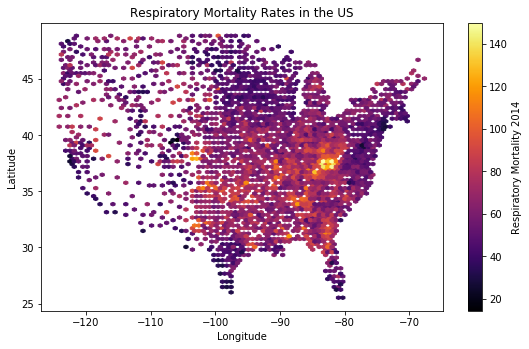

In [144]:
counties2 = counties[['lon','lat','RespMortalityRate2014']]
min_lon = counties['lon'].min()
max_lon = counties['lon'].max()
min_lat = counties['lat'].min()
max_lat = counties['lat'].max()

fig, ax = plt.subplots(figsize = (9,5.3))

hb = ax.hexbin(counties['lon'], counties['lat'], C = counties['RespMortalityRate2014'], gridsize = 85, cmap = 'inferno', bins=None)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Respiratory Mortality 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Respiratory Mortality Rates in the US')
plt.show()

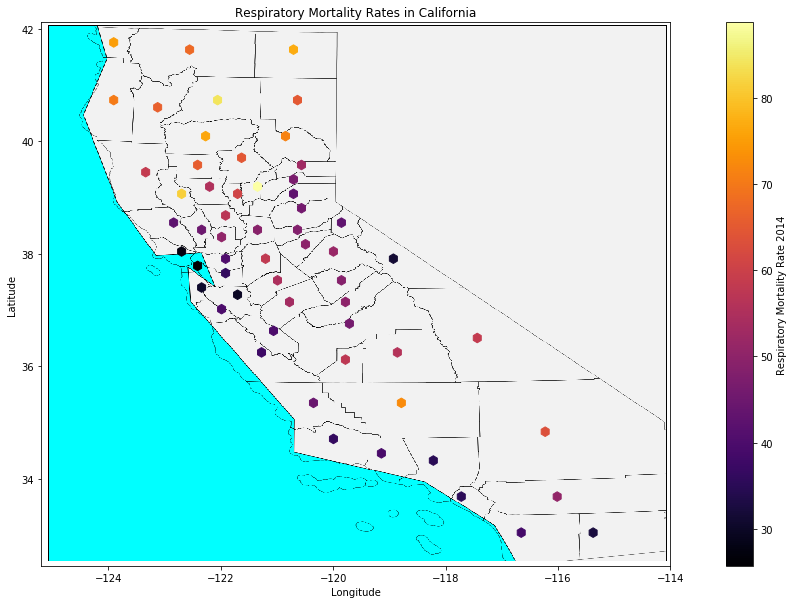

In [145]:
cal2 = cal[['lon','lat','RespMortalityRate2014']]
min_lon = counties['lon'].min()
max_lon = counties['lon'].max()
min_lat = counties['lat'].min()
max_lat = counties['lat'].max()
map_bound1 = (min_lon, max_lon, min_lat, max_lat)
map_bound = (-125.2,-114,32.45,42.12)

basemap = plt.imread('Cali.png')
fig, ax = plt.subplots(figsize = (20,10))


hb = ax.hexbin(cal2['lon'], cal2['lat'], C = cal2['RespMortalityRate2014'], gridsize = 60, cmap = 'inferno', bins=None)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Respiratory Mortality Rate 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Respiratory Mortality Rates in California')

ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal')

plt.show();

In general, northern counties seem to have a high rate of Respiratory Mortality. It'll be interesting to use this feature and see how this might pose more of a risk for some counties than others. Such plots helped us choose features. Further procedures to choose and compute features can be found in the next section on Feature engineering.

## Feature Engineering

### Correlation Plots

In [146]:
grouped_cal_counties = cal_c[['CountyName','SVIPercentile', 'PopulationEstimate2018', '#Hospitals', '#ICU_beds', '#FTEHospitalTotal2017',"TotalM.D.'s,TotNon-FedandFed2017", 'dem_to_rep_ratio','4/18/20']]
grouped_cal_counties = grouped_cal_counties.rename(columns={'4/18/20':'Confirmed'})
grouped_cal_counties['Deaths'] = cal_d['4/18/20']
grouped_cal_counties = grouped_cal_counties.groupby(['CountyName']).mean()
grouped_cal_counties.head()

SVIPercentile  PopulationEstimate2018  #Hospitals  #ICU_beds  \
CountyName                                                                 
Alameda            0.4701               1666753.0        12.0      282.0   
Alpine             0.7287                  1101.0         0.0        0.0   
Amador             0.5334                 39383.0         1.0        6.0   
Butte              0.8064                231256.0         4.0       43.0   
Calaveras          0.2350                 45602.0         1.0        0.0   

            #FTEHospitalTotal2017  TotalM.D.'s,TotNon-FedandFed2017  \
CountyName                                                            
Alameda                   18353.0                            6636.0   
Alpine                        0.0                               2.0   
Amador                      310.0                              77.0   
Butte                      5425.0                             590.0   
Calaveras                   311.0                              60.0   

            dem_to_rep_ratio  Confirmed  Deaths  
CountyName                                       
Alameda             5.367298       1114      41  
Alpine              1.539171          2       0  
Amador              0.572628          7       0  
Butte               0.920765         16       0  
Calaveras           0.587965         12       0

In [147]:
grouped_cal_counties['ICU Beds per 100,000 people'] = grouped_cal_counties['#ICU_beds']/(grouped_cal_counties['PopulationEstimate2018']/100000)
grouped_cal_counties['Full Time Employees per 100,000 people'] =  grouped_cal_counties['#FTEHospitalTotal2017']/(grouped_cal_counties['PopulationEstimate2018']/100000)
grouped_cal_counties['Hospitals per 100,000 people'] = grouped_cal_counties['#Hospitals']/(grouped_cal_counties['PopulationEstimate2018']/100000)
grouped_cal_counties['MDs per 100,000 people'] = grouped_cal_counties["TotalM.D.'s,TotNon-FedandFed2017"]/(grouped_cal_counties['PopulationEstimate2018']/100000)
grouped_cal_counties['Confirmed Cases per 100,000 people'] = grouped_cal_counties["Confirmed"]/(grouped_cal_counties['PopulationEstimate2018']/100000)
grouped_cal_counties['Deaths per 100,000 people'] = grouped_cal_counties["Deaths"]/(grouped_cal_counties['PopulationEstimate2018']/100000)
grouped_cal_counties['Mortality Rate'] = grouped_cal_counties["Deaths"]/grouped_cal_counties['Confirmed']*100

grouped_cal_counties.head()

SVIPercentile  PopulationEstimate2018  #Hospitals  #ICU_beds  \
CountyName                                                                 
Alameda            0.4701               1666753.0        12.0      282.0   
Alpine             0.7287                  1101.0         0.0        0.0   
Amador             0.5334                 39383.0         1.0        6.0   
Butte              0.8064                231256.0         4.0       43.0   
Calaveras          0.2350                 45602.0         1.0        0.0   

            #FTEHospitalTotal2017  TotalM.D.'s,TotNon-FedandFed2017  \
CountyName                                                            
Alameda                   18353.0                            6636.0   
Alpine                        0.0                               2.0   
Amador                      310.0                              77.0   
Butte                      5425.0                             590.0   
Calaveras                   311.0                              60.0   

            dem_to_rep_ratio  Confirmed  Deaths  ICU Beds per 100,000 people  \
CountyName                                                                     
Alameda             5.367298       1114      41                    16.919124   
Alpine              1.539171          2       0                     0.000000   
Amador              0.572628          7       0                    15.235000   
Butte               0.920765         16       0                    18.594112   
Calaveras           0.587965         12       0                     0.000000   

            Full Time Employees per 100,000 people  \
CountyName                                           
Alameda                                1101.122962   
Alpine                                    0.000000   
Amador                                  787.141660   
Butte                                  2345.885080   
Calaveras                               681.987632   

            Hospitals per 100,000 people  MDs per 100,000 people  \
CountyName                                                         
Alameda                         0.719963              398.139376   
Alpine                          0.000000              181.653043   
Amador                          2.539167              195.515832   
Butte                           1.729685              255.128516   
Calaveras                       2.192886              131.573177   

            Confirmed Cases per 100,000 people  Deaths per 100,000 people  \
CountyName                                                                  
Alameda                              66.836538                   2.459873   
Alpine                              181.653043                   0.000000   
Amador                               17.774167                   0.000000   
Butte                                 6.918739                   0.000000   
Calaveras                            26.314635                   0.000000   

            Mortality Rate  
CountyName                  
Alameda           3.680431  
Alpine            0.000000  
Amador            0.000000  
Butte             0.000000  
Calaveras         0.000000

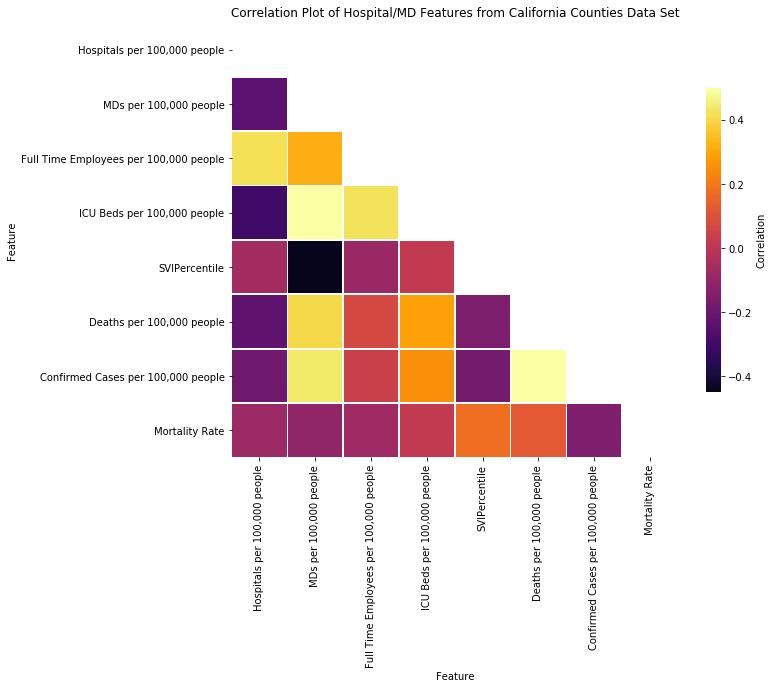

In [148]:
#correlation matrix of hospital/md features

hospital_md_features = grouped_cal_counties[['Hospitals per 100,000 people', 'MDs per 100,000 people',\
        'Full Time Employees per 100,000 people', 'ICU Beds per 100,000 people',\
        'SVIPercentile', 'Deaths per 100,000 people', 'Confirmed Cases per 100,000 people', 'Mortality Rate']]

correl = hospital_md_features.corr() #Correlation


# Generating a mask for the upper triangle
mask_tri = np.zeros_like(correl, dtype=np.bool)
mask_tri[np.triu_indices_from(mask_tri)] = True

# Setting up the matplotlib figure
plt.subplots(figsize=(10, 8))

# Drawing the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(correl, mask=mask_tri, vmax=0.5, center=0,\
                linewidths=0.75,cmap = 'inferno', cbar_kws={"shrink": .7, "label": "Correlation"});

ax.set_title("Correlation Plot of Hospital/MD Features from California Counties Data Set");
ax.set_xlabel("Feature"); ax.set_ylabel("Feature");
plt.show()

Strongest positive correlation evident between deaths per 100,000 and confirmed cases per 100,000. Strong correlation also observed for MDs, Full Time Employees, and ICU Beds per 100,000 people.

We also see that SVIPercentile and MDs per 100,000 people are negatively correlated. It is interesting to note that SVIPercentile has a higher ranking (indicating greater social vulnerability) where there are fewer MDs working to serve that population.

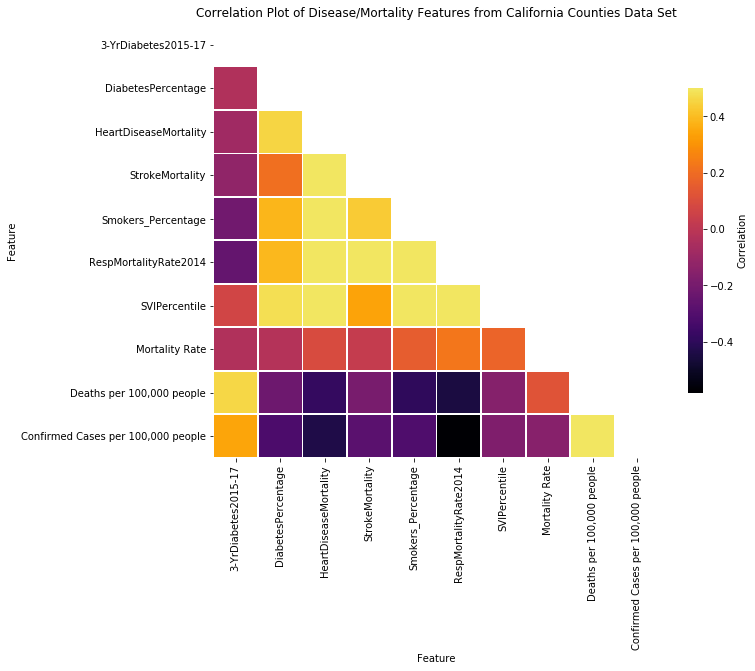

In [149]:
#Correlation matrix of disease mortality rates and covid death/confirmed/mortality rate
disease_mortality = ['CountyName', 'SVIPercentile','3-YrDiabetes2015-17','DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',\
 'Smokers_Percentage', 'RespMortalityRate2014'] 
grouped_cal_counties2 = cal_c[disease_mortality]
grouped_cal_counties2['Confirmed'] = cal_c['4/18/20']
grouped_cal_counties2['Deaths'] = cal_d['4/18/20']
grouped_cal_counties2['Confirmed Cases per 100,000 people'] = grouped_cal_counties['Confirmed Cases per 100,000 people'].tolist()
grouped_cal_counties2['Deaths per 100,000 people'] = grouped_cal_counties['Deaths per 100,000 people'].tolist()
grouped_cal_counties2['Mortality Rate'] = grouped_cal_counties['Mortality Rate'].tolist()

grouped_cal_counties2.head()

disease_mortality_features = grouped_cal_counties2[['3-YrDiabetes2015-17','DiabetesPercentage',\
    'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014',\
    'SVIPercentile', 'Mortality Rate', 'Deaths per 100,000 people',\
    'Confirmed Cases per 100,000 people']]

correl2 = disease_mortality_features.corr() #Correlation


# Generating a mask for the upper triangle
mask_tri2 = np.zeros_like(correl2, dtype=np.bool)
mask_tri2[np.triu_indices_from(mask_tri2)] = True

# Setting up the matplotlib figure
plt.subplots(figsize=(10, 8))


# Drawing the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(correl2, mask=mask_tri2, vmax=0.5, center=0,\
                linewidths=0.75,cmap = 'inferno', cbar_kws={"shrink": .7, "label": "Correlation"});

ax.set_title("Correlation Plot of Disease/Mortality Features from California Counties Data Set");
ax.set_xlabel("Feature"); ax.set_ylabel("Feature");
plt.show()


It is interesting to note strong correlation between # of deaths, # of confirmed cases and 3-Yr Diabetes data (estimated percentage of people with diabetes).

SVIPercentile is also strongly correlated with diabetes percentage, heart disease mortality, stroke mortality, and % of smokers. There is greater social vulnerability in counties with higher mortality rates, greater % of people with diabetes, and higher % of smokers. This is interesting to note, especially since we can compare this insight to our previous correlation, where there were lower MDs per 100,000 people in counties with greater SVIPercentile (greater social vulnerability)

### Finding Incidence Rate

This calcualtion has been done to see number of new cases in a county per unit of population in a given time period (2 weeks). Reference: https://www.cdc.gov/csels/dsepd/ss1978/lesson3/section2.html

Filtering data for latest 2 weeks from 27th Apri lto 11th May for all counties:

In [150]:
cal_week = cal_timeseries1[(cal_timeseries1['Date'] == ('2020-04-27')) | (cal_timeseries1['Date'] == ('2020-05-11'))]
cal_week.shape

(116, 3)

In [151]:
cal_week = cal_week[['CountyName','value']]
cal_week_group = cal_week.groupby('CountyName').agg(np.diff)

In [152]:
cal_week_updated_group = cal_week_group.reset_index()
cal_week_updated_group.head()

CountyName  value
0    Alameda    601
1     Alpine      0
2     Amador      0
3      Butte      4
4  Calaveras      0

In [153]:
cal_week_updated_group['Population'] = cal['PopulationEstimate2018'].reset_index(drop=True)
cal_week_updated_group['Incidence Rate'] = cal_week_updated_group['value']/cal_week_updated_group['Population']
cal_week_confirmed_rates = cal_week_updated_group.rename(columns = {'value':'Total'})
cal_week_confirmed_rates.head()

CountyName  Total  Population  Incidence Rate
0    Alameda    601   1666753.0        0.000361
1     Alpine      0      1101.0        0.000000
2     Amador      0     39383.0        0.000000
3      Butte      4    231256.0        0.000017
4  Calaveras      0     45602.0        0.000000

### Mortality rate ####

Similar to incidence rate calculation - number of deaths per unit of population in 2 weeks. Again, filtering data for  two weeks leading up to 11th May.

In [154]:
cal_week = cal_timeseries2[(cal_timeseries2['Date'] == ('2020-04-27')) | (cal_timeseries2['Date'] == ('2020-05-11'))]
cal_week.shape

(116, 3)

In [155]:
cal_week_updated = cal_week[['CountyName','value']]
cal_week_updated_group = cal_week_updated.groupby('CountyName').agg(np.diff)
cal_week_updated_group.head()

value
CountyName       
Alameda        19
Alpine          0
Amador          0
Butte           0
Calaveras       0

In [156]:
cal_week_updated_group = cal_week_updated_group.reset_index()

In [157]:
cal_week_updated_group['Population'] = cal['PopulationEstimate2018'].reset_index(drop=True)
cal_week_updated_group['Mortality Rate'] = cal_week_updated_group['value']/cal_week_updated_group['Population']
cal_week_death_rates = cal_week_updated_group.rename(columns = {'value':'Total'})
cal_week_death_rates.head()

CountyName  Total  Population  Mortality Rate
0    Alameda     19   1666753.0        0.000011
1     Alpine      0      1101.0        0.000000
2     Amador      0     39383.0        0.000000
3      Butte      0    231256.0        0.000000
4  Calaveras      0     45602.0        0.000000

### Some more features ###

In [158]:
Cluster_data = cal_week_death_rates[['CountyName','Mortality Rate']]
Cluster_data['Incidence Rate'] = cal_week_confirmed_rates['Incidence Rate']
Cluster_data['Population'] = cal['PopulationEstimate2018'].reset_index(drop=True)
Cluster_data['Hospitals'] = cal['#Hospitals'].reset_index(drop=True)
Cluster_data['ICU_beds'] = cal['#ICU_beds'].reset_index(drop=True)
Cluster_data['SVIP'] = cal['SVIPercentile'].reset_index(drop=True)

Using original County mortality rates. By doing fillna(np.mean) on the original dataset, some smaller counties might have been filled with a big value. Relative to their small population, a large number of mortalities can skew our idea of their mortality risk.

Therefore we'll later fill with the average of rates and not the average of absolute numbers just for this section.

Another feature we can use is the cumulative mortality rate for people of age 25-44. This is the age bracket that has the highest proportion of cases in California according to the California Health and Human services:
https://public.tableau.com/views/COVID-19PublicDashboard/Covid-19Public?:embed=y&:display_count=no&:showVizHome=no

In [159]:
cal2 = counties[counties['StateName'] == 'CA']
Cluster_data['Mortality25-34'] = cal2['3-YrMortalityAge25-34Years2015-17'].reset_index(drop=True)
Cluster_data['Mortality35-44'] = cal2['3-YrMortalityAge35-44Years2015-17'].reset_index(drop=True)
Cluster_data['Mortality25-44%'] = (Cluster_data['Mortality35-44'] + Cluster_data['Mortality25-34'])/Cluster_data['Population']
Cluster_data = Cluster_data.fillna(np.mean(Cluster_data))

Cluster_data['#People_per_ICU_Bed'] = Cluster_data['Population']/Cluster_data['ICU_beds']
Cluster_data.head()

CountyName  Mortality Rate  Incidence Rate  Population  Hospitals  ICU_beds  \
0    Alameda        0.000011        0.000361   1666753.0       12.0     282.0   
1     Alpine        0.000000        0.000000      1101.0        0.0       0.0   
2     Amador        0.000000        0.000000     39383.0        1.0       6.0   
3      Butte        0.000000        0.000017    231256.0        4.0      43.0   
4  Calaveras        0.000000        0.000000     45602.0        1.0       0.0   

     SVIP  Mortality25-34  Mortality35-44  Mortality25-44%  \
0  0.4701      186.000000      264.000000         0.000270   
1  0.7287      121.780488      158.772727         0.000345   
2  0.5334      121.780488      158.772727         0.000345   
3  0.8064       39.000000       51.000000         0.000389   
4  0.2350      121.780488      158.772727         0.000345   

   #People_per_ICU_Bed  
0          5910.471631  
1                  inf  
2          6563.833333  
3          5378.046512  
4                  inf

For #People_per_ICU_Bed, some small counties have reported 0 ICU beds. As a result, we get a value of 'inf' when dividing the population by 0. Having 0 ICU beds can very negatively impact a county's ability to fight the disease. Yet, filling these small counties with a mean calculated over the larger counties might be misrepresentative. Lower the #People_per_ICU_Bed the better it is for the county, so we can;t fill these with 0. We decided to rather fill these with the original population of the county.

In [160]:
refined = []
Cluster_data[Cluster_data['#People_per_ICU_Bed'] == math.inf].index

for i in np.arange(len(Cluster_data['#People_per_ICU_Bed'])):
    if Cluster_data['#People_per_ICU_Bed'][i] != math.inf:
        refined.append(Cluster_data['#People_per_ICU_Bed'][i])
    else:
        pop = Cluster_data['Population'][i]
        refined.append(pop)
        
Cluster_data['#People_per_ICU_Bed'] = refined

Cluster_data['MDs'] = cal["TotalM.D.'s,TotNon-FedandFed2017"].reset_index(drop = True)
Cluster_data['People per MD'] = Cluster_data['Population']/Cluster_data['MDs']
Cluster_data.head()

CountyName  Mortality Rate  Incidence Rate  Population  Hospitals  ICU_beds  \
0    Alameda        0.000011        0.000361   1666753.0       12.0     282.0   
1     Alpine        0.000000        0.000000      1101.0        0.0       0.0   
2     Amador        0.000000        0.000000     39383.0        1.0       6.0   
3      Butte        0.000000        0.000017    231256.0        4.0      43.0   
4  Calaveras        0.000000        0.000000     45602.0        1.0       0.0   

     SVIP  Mortality25-34  Mortality35-44  Mortality25-44%  \
0  0.4701      186.000000      264.000000         0.000270   
1  0.7287      121.780488      158.772727         0.000345   
2  0.5334      121.780488      158.772727         0.000345   
3  0.8064       39.000000       51.000000         0.000389   
4  0.2350      121.780488      158.772727         0.000345   

   #People_per_ICU_Bed     MDs  People per MD  
0          5910.471631  6636.0     251.168324  
1          1101.000000     2.0     550.500000  
2          6563.833333    77.0     511.467532  
3          5378.046512   590.0     391.959322  
4         45602.000000    60.0     760.033333

In [161]:
Cluster_data['RespMortality'] = cal['RespMortalityRate2014'].reset_index(drop=True)

Cluster_data = Cluster_data.set_index('CountyName')
Cluster_data_final = Cluster_data[['Mortality Rate','Incidence Rate','#People_per_ICU_Bed','RespMortality','Mortality25-44%','SVIP']]
Cluster_data_final

Mortality Rate  Incidence Rate  #People_per_ICU_Bed  \
CountyName                                                             
Alameda                0.000011        0.000361          5910.471631   
Alpine                 0.000000        0.000000          1101.000000   
Amador                 0.000000        0.000000          6563.833333   
Butte                  0.000000        0.000017          5378.046512   
Calaveras              0.000000        0.000000         45602.000000   
Colusa                 0.000000        0.000000         21627.000000   
Contra Costa           0.000006        0.000198          7056.533742   
Del Norte              0.000000        0.000000          4638.000000   
El Dorado              0.000000        0.000073          6809.928571   
Fresno                 0.000002        0.000490          6063.414634   
Glenn                  0.000000        0.000036         28047.000000   
Humboldt               0.000000        0.000059          4261.656250   
Imperial               0.000022        0.001556          6493.821429   
Inyo                   0.000000        0.000000          4496.750000   
Kern                   0.000011        0.000511          6227.527778   
Kings                  0.000000        0.001665          6880.272727   
Lake                   0.000000        0.000031          8047.750000   
Lassen                 0.000000        0.000000         30802.000000   
Los Angeles            0.000062        0.001172          4753.301035   
Madera                 0.000000        0.000165         15767.200000   
Marin                  0.000008        0.000158          3934.333333   
Mariposa               0.000000        0.000859         17471.000000   
Mendocino              0.000000        0.000011          6257.571429   
Merced                 0.000000        0.000237         11448.541667   
Modoc                  0.000000        0.000000          8777.000000   
Mono                   0.000000        0.000561          7125.000000   
Monterey               0.000005        0.000220         16133.111111   
Napa                   0.000007        0.000108          4356.781250   
Nevada                 0.000000        0.000040          9969.600000   
Orange                 0.000012        0.000449          4893.960061   
Placer                 0.000000        0.000069          5616.414286   
Plumas                 0.000000        0.000000         18804.000000   
Riverside              0.000031        0.000631          6982.216524   
Sacramento             0.000006        0.000083          3891.351010   
San Benito             0.000000        0.000146          7692.125000   
San Bernardino         0.000015        0.000572          5296.592683   
San Diego              0.000019        0.000605          5865.550877   
San Francisco          0.000014        0.000600          2621.083086   
San Joaquin            0.000005        0.000124          6220.330579   
San Luis Obispo        0.000000        0.000201          6174.130435   
San Mateo              0.000019        0.000499          5874.389313   
Santa Barbara          0.000009        0.001995          5445.451220   
Santa Clara            0.000013        0.000122          6190.319489   
Santa Cruz             0.000000        0.000062         12466.136364   
Shasta                 0.000000        0.000011          2222.716049   
Sierra                 0.000000        0.000000          2987.000000   
Siskiyou               0.000000        0.000000         10931.000000   
Solano                 0.000013        0.000403          4854.456522   
Sonoma                 0.000004        0.000178          6096.853659   
Stanislaus             0.000029        0.000389          6247.897727   
Sutter                -0.000010       -0.000114         96807.000000   
Tehama                 0.000000        0.000000          7989.500000   
Trinity                0.000000        0.000080         12535.000000   
Tulare                 0.000039        0.001346          

## Dimensionality Reduction ##

Reducing this 6 dimensional Feature dataframe and approximating using the first 2 Principal Components in order to Implement Clustering Methods. We will start by normalizing the **Cluster_data_final** data frame.

In [162]:
df_cluster = (Cluster_data_final - np.mean(Cluster_data_final))/(np.var(Cluster_data_final))**(0.5)
df_cluster.head()

Mortality Rate  Incidence Rate  #People_per_ICU_Bed  \
CountyName                                                        
Alameda           0.404668        0.139891            -0.336838   
Alpine           -0.553897       -0.668712            -0.688434   
Amador           -0.553897       -0.668712            -0.289074   
Butte            -0.553897       -0.629924            -0.375761   
Calaveras        -0.553897       -0.668712             2.564811   

            RespMortality  Mortality25-44%      SVIP  
CountyName                                            
Alameda         -1.064532    -8.607418e-01 -0.624090  
Alpine          -0.617702    -6.190409e-16  0.358217  
Amador          -0.251873    -6.190409e-16 -0.383641  
Butte            0.843624     5.003583e-01  0.653365  
Calaveras       -0.168217    -6.190409e-16 -1.517131

In [163]:
u,s,vt = np.linalg.svd(df_cluster, full_matrices = False)

first_2_pcs = (df_cluster @ vt.T)[[0,1]]
first_2_pcs = first_2_pcs.rename(columns = {0: "pc1", 1: "pc2"}).reset_index(drop = True)
first_2_pcs.head() 

pc1       pc2
0 -1.554837 -0.276800
1  0.016489 -0.347722
2  0.038013 -0.809291
3  1.298317  0.017587
4  0.225468 -2.155494

Text(0.5, 1.0, 'Principal Components Graph for California Counties')

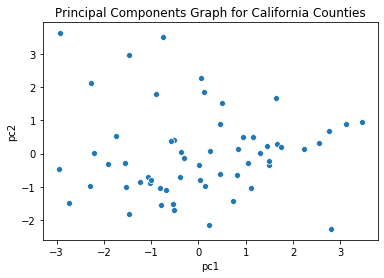

In [164]:
sns.scatterplot(data = first_2_pcs, x = "pc1", y = "pc2");
plt.title('Principal Components Graph for California Counties')

In [165]:
fig = px.scatter(first_2_pcs, x="pc1", y="pc2", text = list(df_cluster.index))

fig.update_traces(textposition='top center')

fig.update_layout(
    title_text='Graph of pc1 and pc2 for all Counties in California'
)

fig.show()

Let's see how much variance is captured by the first two Principal Components.

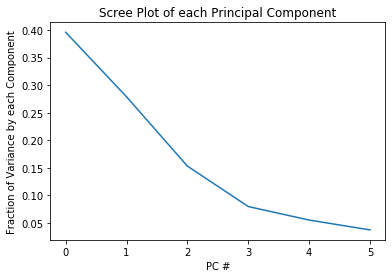

In [166]:
# Scree Plot

plt.plot(np.arange(6), s**2 / sum(s**2));
plt.xticks(np.arange(0,6,1), np.arange(0,6,1));
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance by each Component')
plt.title("Scree Plot of each Principal Component");

Looks like it's a little below 70% which seems very reasonable. Let us now try to observe the clusters in this plot better.

## Identifying Risk Zones using K-Means and Agglomerative Clustering

By reducing the 5 dimensional Cluster_data_final feature matrix into 2 dimensions, we can now cluster these into zones that are similar. 

The idea behind doing this is that in countries like India, different cities and hotspots have been classified as Red zones. Orange zones face less risk and Green zones have minimal risk with respect to the virus. Administration of COVID-19 related rules can be done better when Districts are zoned as such. Likewise, we can zone different counties in California using clustering to see which zones face the highest risk at the moment and which counties are relatively safer.

In [167]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

X = first_2_pcs.copy()
y_km = km.fit_predict(X)
y_km

array([1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1,
       2, 1, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2], dtype=int32)

In [168]:
X['Groups'] = y_km

In [169]:
X['County'] = list(df_cluster.index)
fig = px.scatter(X, x="pc1", y="pc2", hover_data = ['County'], color = 'Groups', color_continuous_scale=["red", "orange", "green"])
fig.update_layout(
    title_text='K-Means Clustering into 3 zones'
)
fig.show()

We can see three clear zones:

***Red Zone*** contains large, high-risk counties like Los Angeles, Riverside, Santa barbara, etc.

***Orange Zone*** consists of lower risk counties like Orange, Marin, Sonoma, Napa, San Luis Obispo, San Francisco, San Diego, Santa Cruz, Monterey etc.

***Green Zone*** consists of even smaller, very low-risk counties like Yuba, Lake, Sutter, Shasta, Humboldt, Kern, Siskiyou, etc.

It can also be deduced that generally moving left to right, the risk of the county decreases. The high-risk zones, like LA, have low pc1, high pc2. Low-risk zones like Yuba and Sutter tend to have lower pc2 and higher pc1. This method also shows some medium-sized counties that may also be high-risk zones like Imperial, Tulare, and Kings.

However, Fresno and San Bernandino seem to be pretty close to each other and they are still classified as Green and Red. For a Red and Green zone to be so close on the graph probably indicates that a slightly better clustering method might give more continuity between the progression of counties from Red to Orange to Green.

In [170]:
from sklearn.cluster import AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters=3)

X = first_2_pcs.copy()
y_ag = ag.fit_predict(X)
y_ag

array([0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 2, 0, 0,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0,
       2, 0, 2, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 2])

In [171]:
X['Groups'] = y_ag
X['County'] = list(df_cluster.index)
fig = px.scatter(X, x="pc1", y="pc2", hover_data = ['County'], color = 'Groups', color_continuous_scale=["orange", "red", "green"])
fig.update_layout(
    title_text='Agglomerative Clustering into 3 zones'
)
fig.show()

The clusters look more or less similar, with Fresno and Kern that were previously Green zones now showing as Red zones. This doesn’t seem like a better model since it didn’t align with our intuition that higher the PC1 value, the safer the county. Fresno falls in between but Kern is too far right to be classified as Red.

We feel that for a clustering model, it is better to classify a Green zone as Red than vice versa. Thus, the K-Means model seems better than the Agglomerative model. We feel that considering the latest news sources, the K-Means clustering more accurately shows which zones are high and low risk and also shows some zones other than big counties that may be at risk. News source: https://www.dailynews.com/2020/04/03/watch-the-stunning-growth-of-coronavirus-cases-in-californias-hardest-hit-counties/

All in all, these seem to be pretty good representations of clustering the counties in California that have been impacted the most by COVID-19. Taking into account other factors like ICU beds per person, Respiratory Mortality rates, general 3-year mortality rates, and Social Vulnerability Percentiles, we get clusters that intuitively make sense. There are few Red counties and quite a few Green counties, which aligns with the fact that California is faring well. However, there are a lot of Orange zones too, including big counties like Santa Clara and San Francisco. 

Of course, these zones are based on latest data. It doesn't take into account future predictions for each state and other factors like recovery rate.

# Modeling of Covid-19 Infected and Deaths

In order to accurately predict the final number of infected individuals and mortality rate, we must build a model based on current trends; however, before exploring potential models, we must first visualize the current data to shortlist possible models. 

## Confirmed Covid-19 Cases in California

In [172]:
fig = px.line(cal_timeseries1, x="Date", y="value", color="CountyName", hover_name="CountyName")
fig.update_layout(
    title="Confirmed Cases of Covid-19 in California Counties",
    yaxis_title="Number of confirmed cases (by thousand of people)",
    )
fig.show()

The graph above indicates that the number of confirmed cases are increasing in California counties; however, the rate at which they are increasing, as well as the number of cases in each county, varies. It is evident that Los Angeles has the highest number of cases, and is likely increasing the quickest. However, it is difficult to identify if coronavirus is spreading linearly or exponentially in each county. 

## Log of Confirmed Covid-19 Cases in California

In [173]:
cal_timeseries1['log'] = np.log1p(cal_timeseries1['value'])

In [174]:
fig = px.line(cal_timeseries1, x="Date", y="log", color="CountyName", hover_name="CountyName")
fig.update_layout(
    title="Log of Confirmed Cases of Covid-19 in California Counties",
    yaxis_title="Log of Number of confirmed cases (by thousand of people)",
    )
fig.show()

Placing the confirmed cases in California counties in a logarithmic scale aids in better understanding the growth trends of the virus. The graph reveals that the spread of the virus follows a similar pattern in most counties; however, the virus growth is levelling off and, while is still increasing, is approaching a plateau. 

## Covid-19 Deaths in California

In [175]:
fig = px.line(cal_timeseries2, x="Date", y="value", color="CountyName", hover_name="CountyName")
fig.update_layout(
    title="Confirmed Deaths due to Covid-19 in California Counties",
    yaxis_title="Log of Number of Confirmed Deaths",
    )
fig.show()

The trends of deaths in California due to coronavirus are similar to that of the trends of the coronavirus spread within the state. Both graphs indicate the virus is spreading linearly or exponentially. The primarly different between the graph of confirmed coronavirus cases and coronavirus deaths is the y-axis values. In order to gain a better understanding of the Covid-19 death rate, we must look at the logarithmic graph of coronavirus deaths in California. 

In [176]:
cal_timeseries2['log'] = np.log1p(cal_timeseries2['value'])

In [177]:
fig = px.line(cal_timeseries2, x="Date", y="log", color="CountyName", hover_name="CountyName")
fig.update_layout(
    title="Log of Confirmed Deaths of Covid-19 in California Counties",
    yaxis_title="Log of Number of Deaths",
    )
fig.show()

As previously stated, the logarithm of the coronavirus deaths graph is similar to the graph of the logarithm of the coronavirus confirmed cases graph. This indicates that, similar to the spread of the virus, the deaths due to coronavirus are increasing exponentially, but are approaching a plateau soon. 

Similar to the graph of confirmed cases, the number of deaths due to Covid-19 also follows a logistical regression. This confirms that a logistical model will best predict the confirmed cases and deaths due to coronavirus.

Overall, a logisical model is the best method to predict the final number of infected people and mortality rate. There are several other research papers that support this theory; however, it is undetermined if this model can work in all settings. 

## Developing the Model 

Based on the graphs above of the confirmed coronavirus cases and coronavirus deaths, in order to model and predict the number of infected people and the number of deaths due to coronavirus, it is likely that we will need to implement an exponential or logistic model. To understand this better, we decided to split the currently available data into train and test data, fit an exponential and logistic model to this data, and calculate each model's error to determine the better fit. 

### Train/Test Data 

In [178]:
sf_c = cal_timeseries1[cal_timeseries1['CountyName'] == 'San Francisco'].reset_index()
sf_c['Days'] = list(np.arange(sf_c.shape[0]))
sf_d = cal_timeseries2[cal_timeseries2['CountyName'] == 'San Francisco'].reset_index()
sf_d['Days'] = list(np.arange(sf_d.shape[0]))

In [179]:
#Splitting the data into a train and test. Any data prior to May 1st is part of the training data
# and all data from May 1st to date is part of the testing data. 
sf_train_c = sf_c.loc[:99]
sf_test_c = sf_c.loc[100:]
sf_train_d = sf_d.loc[:99]
sf_test_d = sf_d.loc[100:]     

In [180]:
sf_train_c

index     CountyName       Date  value       log  Days
0      37  San Francisco 2020-01-22      0  0.000000     0
1      95  San Francisco 2020-01-23      0  0.000000     1
2     153  San Francisco 2020-01-24      0  0.000000     2
3     211  San Francisco 2020-01-25      0  0.000000     3
4     269  San Francisco 2020-01-26      0  0.000000     4
..    ...            ...        ...    ...       ...   ...
95   5547  San Francisco 2020-04-26   1408  7.250636    95
96   5605  San Francisco 2020-04-27   1424  7.261927    96
97   5663  San Francisco 2020-04-28   1468  7.292337    97
98   5721  San Francisco 2020-04-29   1490  7.307202    98
99   5779  San Francisco 2020-04-30   1499  7.313220    99

[100 rows x 6 columns]

### RMSE Function

In [181]:
#Function to calculate to rmse of each model. 
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

### Exponential Modeling with Scikit Learn 

In [182]:
#Using Scikit Learn Exponential Regression model to predict confirmed cases and deaths. 
exp_model_c = lm.LinearRegression()
exp_model_c.fit(sf_train_c[['Days']], sf_train_c['value'])

exp_model_d = lm.LinearRegression()
exp_model_d.fit(sf_train_d[['Days']], sf_train_d['value'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [183]:
exp_pred_c = exp_model_c.predict(sf_test_c[['Days']])
exp_pred_d = exp_model_d.predict(sf_test_d[['Days']])

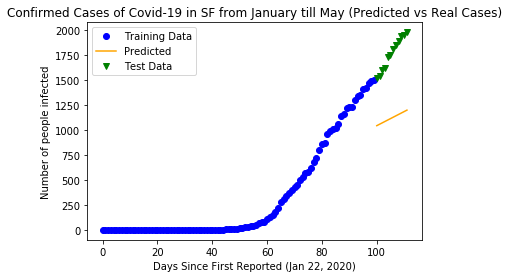

In [184]:
ax = plt.subplot()
ax.plot(sf_train_c['Days'], sf_train_c['value'], 'o', color = 'blue', label = 'Training Data') #Blue - Actual cases until April 30th
ax.plot(sf_test_c['Days'], exp_pred_c, '-', color = 'orange', label = 'Predicted') #Orange - Predicted cases for month of May
ax.plot(sf_test_c['Days'], sf_test_c['value'], 'v', color = 'green', label = 'Test Data') #Green - Actual cases for month of May
plt.ylabel("Number of people infected")
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.title("Confirmed Cases of Covid-19 in SF from January till May (Predicted vs Real Cases)")
plt.legend();

In [185]:
print('RMSE of Scikit Learn Exponential Model for Confirmed Cases: ', rmse(sf_test_c['value'], exp_pred_c))

RMSE of Scikit Learn Exponential Model for Confirmed Cases:  655.1742290590674


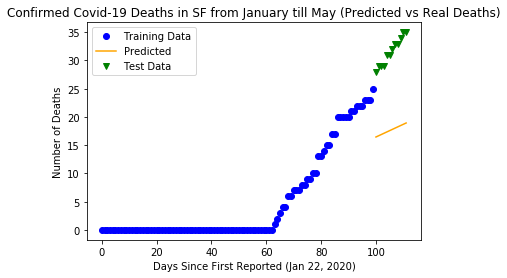

In [186]:
ax = plt.subplot()
ax.plot(sf_train_d['Days'], sf_train_d['value'], 'o', color = 'blue', label = 'Training Data') #Blue - Actual deaths until April 30th
ax.plot(sf_test_d['Days'], exp_pred_d, '-', color = 'orange', label = 'Predicted') #Orange - Predicted deaths for month of May determined by model
ax.plot(sf_test_d['Days'], sf_test_d['value'], 'v', color = 'green', label = 'Test Data') #Green - Actual deaths for month of May
plt.ylabel("Number of Deaths")
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.title("Confirmed Covid-19 Deaths in SF from January till May (Predicted vs Real Deaths)")
plt.legend();

In [187]:
print('RMSE of Scikit Learn Exponential Model for Confirmed Deaths: ', rmse(sf_test_d['value'], exp_pred_d))

RMSE of Scikit Learn Exponential Model for Confirmed Deaths:  13.981281015239954


### Exponential Modeling with Functions

In [188]:
#Defining an exponential model function
def exp_model(a,b,t):
    return a*np.e**(b*t)

In [189]:
#Using the function and fitting it to the training data to obtain a better, more accurate model. 
exp_fit_c = curve_fit(exp_model,sf_train_c['Days'].to_numpy(), sf_train_c['value'].to_numpy())
exp_fit_d = curve_fit(exp_model,sf_train_d['Days'].to_numpy(), sf_train_d['value'].to_numpy())
a1, b2 = exp_fit_c[0][0], exp_fit_c[0][1]
a11, b22 = exp_fit_d[0][0], exp_fit_d[0][1] 
a1,b2,a11,b22

(1.3075877717866442,
 1.6408688778508673,
 -99.47541868352113,
 100.52458131647879)

In [190]:
pred_exp_c = exp_model(a1,b2, sf_test_c['Days'])
pred_exp_d = exp_model(a11,b22, sf_test_d['Days'])

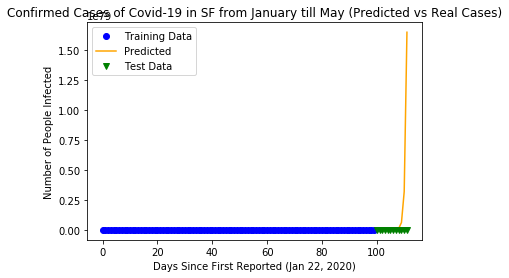

In [191]:
#Plot predicted cases vs real cases in the month of May. 
fig, ax = plt.subplots()
ax.plot(sf_train_c['Days'], sf_train_c['value'], 'o', color = 'blue', label = 'Training Data') #Blue - Actual cases until April 30th
ax.plot(sf_test_c['Days'], pred_exp_c, '-', color = 'orange', label = 'Predicted') #Orange - Predicted cases for month of May
ax.plot(sf_test_c['Days'], sf_test_c['value'], 'v', color = 'green', label = 'Test Data') #Green - Actual cases for month of May
plt.ylabel("Number of People Infected")
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.title("Confirmed Cases of Covid-19 in SF from January till May (Predicted vs Real Cases)")
plt.legend();

In [192]:
print('RMSE of Exponential Model Function for Confirmed Cases: ', rmse(sf_test_c['value'], pred_exp_c))

RMSE of Exponential Model Function for Confirmed Cases:  4.853413165582506e+78


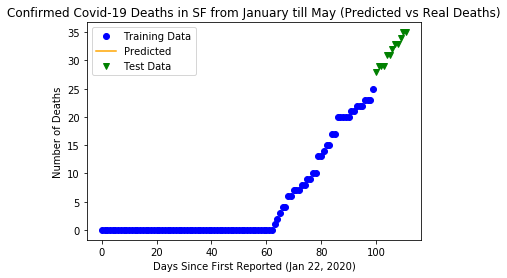

In [193]:
#Plot predicted deaths vs actual deaths in the month of May. 
fig, ax = plt.subplots()
ax.plot(sf_train_d['Days'], sf_train_d['value'], 'o', color = 'blue', label = 'Training Data') #Blue - Actual deaths until April 30th
ax.plot(sf_test_d['Days'], pred_exp_d, '-', color = 'orange', label = 'Predicted') #Orange - Predicted deaths for month of May
ax.plot(sf_test_d['Days'], sf_test_d['value'], 'v', color = 'green', label = 'Test Data') #Green - Actual deaths for month of May
plt.ylabel("Number of Deaths")
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.title("Confirmed Covid-19 Deaths in SF from January till May (Predicted vs Real Deaths)")
plt.legend();

In [194]:
print('RMSE of Exponential Model Function for Confirmed Deaths: ', rmse(sf_test_d['value'], pred_exp_d))

RMSE of Exponential Model Function for Confirmed Deaths:  inf


In this case, it is evident that the Scikit Learn exponential model provides a better prediction of deaths and confirmed cases in comparison to the exponential model function. The RMSE for the exponential function model for both confirmed cases and deaths are extremely high (the rmse for deaths is infinite) whereas the Scikit learn exponential model is much lower. However, the error rate for the exponential model is still large, thus it is important to also consider a logistical model. 

### Logistical Modeling with Scikit Learn

In [195]:
log_model_c = LogisticRegression(solver="lbfgs", max_iter=10000)
log_model_d = LogisticRegression(solver="lbfgs", max_iter=10000)

In [196]:
log_model_c.fit(sf_train_c[['Days']], sf_train_c['value'])
log_model_d.fit(sf_train_d[['Days']], sf_train_d['value'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [197]:
log_pred_c = log_model_c.predict(sf_test_c[['Days']])
log_pred_d = log_model_d.predict(sf_test_d[['Days']])

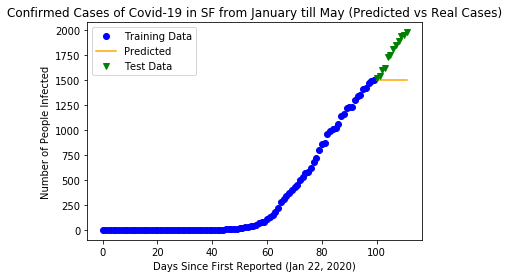

In [198]:
#Plot predicted cases vs real cases in the month of May. 
fig, ax = plt.subplots()
ax.plot(sf_train_c['Days'], sf_train_c['value'], 'o', color = 'blue', label = 'Training Data') #Blue - Actual cases until April 30th
ax.plot(sf_test_c['Days'], log_pred_c, '-', color = 'orange', label = 'Predicted') #Orange - Predicted cases for month of May
ax.plot(sf_test_c['Days'], sf_test_c['value'], 'v', color = 'green', label = 'Test Data') #Green - Actual cases for month of May
plt.ylabel("Number of People Infected")
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.title("Confirmed Cases of Covid-19 in SF from January till May (Predicted vs Real Cases)")
plt.legend();

In [199]:
print('RMSE of Logistic Model Scikit Learn for Confirmed Cases: ', rmse(sf_test_c['value'], log_pred_c))

RMSE of Logistic Model Scikit Learn for Confirmed Cases:  309.8502326393619


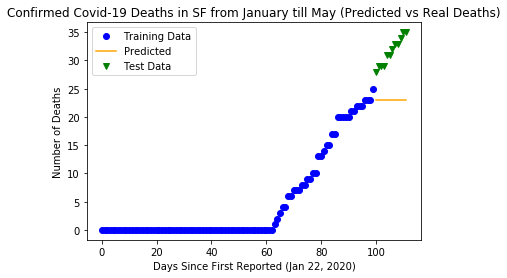

In [200]:
#Plot predicted deaths vs real deaths in the month of May. 
fig, ax = plt.subplots()
ax.plot(sf_train_d['Days'], sf_train_d['value'], 'o', color = 'blue', label = 'Training Data') #Blue - Actual deaths until April 30th
ax.plot(sf_test_d['Days'], log_pred_d, '-', color = 'orange', label = 'Predicted') #Orange - Predicted deaths for month of May
ax.plot(sf_test_d['Days'], sf_test_d['value'], 'v', color = 'green', label = 'Test Data') #Green - Actual deaths for month of May
plt.ylabel("Number of Deaths")
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.title("Confirmed Covid-19 Deaths in SF from January till May (Predicted vs Real Deaths)")
plt.legend();

In [201]:
print('RMSE of Logistic Model Scikit Learn for Confirmed Deaths: ', rmse(sf_test_d['value'], log_pred_d))

RMSE of Logistic Model Scikit Learn for Confirmed Deaths:  8.902246907382429


### Logistical Modeling with Functions

In [202]:
def logistic_model(t, a, b ,c):
    return c / (1. + a*np.exp(-t*b))

In [203]:
log_fit_c = curve_fit(logistic_model,sf_train_c['Days'].to_numpy(), sf_train_c['value'].to_numpy())
log_fit_d = curve_fit(logistic_model,sf_train_d['Days'].to_numpy(), sf_train_d['value'].to_numpy())

a2, b3, c4 = log_fit_c[0][0], log_fit_c[0][1], log_fit_c[0][2]
a22, b33, c44 = log_fit_d[0][0], log_fit_d[0][1], log_fit_d[0][2]
a2, b3,a22, b33, c4, c44

(13861.62979940683,
 0.12009680724908102,
 139007.61302050645,
 0.15031501374658074,
 1606.1279799416573,
 24.552412220545637)

In [204]:
pred_log_c = logistic_model(sf_test_c['Days'], a2, b3, c4)
pred_log_d = logistic_model(sf_test_d['Days'], a22, b33, c44)

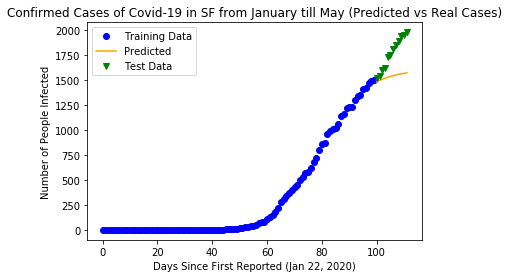

In [205]:
#Plot predicted cases vs real cases in the month of May. 
fig, ax = plt.subplots()
ax.plot(sf_train_c['Days'], sf_train_c['value'], 'o', color = 'blue', label = 'Training Data') #Blue - Actual cases until April 30th
ax.plot(sf_test_c['Days'], pred_log_c, '-', color = 'orange', label = 'Predicted') #Orange - Predicted cases for month of May
ax.plot(sf_test_c['Days'], sf_test_c['value'], 'v', color = 'green', label = 'Test Data') #Green - Actual cases for month of May
plt.ylabel("Number of People Infected")
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.title("Confirmed Cases of Covid-19 in SF from January till May (Predicted vs Real Cases)")
plt.legend();

In [206]:
print('RMSE of Logistic Model Function for Confirmed Cases: ', rmse(sf_test_c['value'], pred_log_c))

RMSE of Logistic Model Function for Confirmed Cases:  265.779700783575


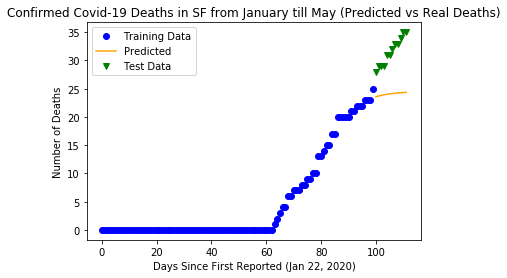

In [207]:
#Plot predicted deaths vs real deaths in the month of May. 
fig, ax = plt.subplots()
ax.plot(sf_train_d['Days'], sf_train_d['value'], 'o', color = 'blue', label = 'Training Data') #Blue - Actual deaths until April 30th
ax.plot(sf_test_d['Days'], pred_log_d, '-', color = 'orange', label = 'Predicted') #Orange - Predicted deaths for month of May
ax.plot(sf_test_d['Days'], sf_test_d['value'], 'v', color = 'green', label = 'Test Data') #Green - Actual deaths for month of May
plt.ylabel("Number of Deaths")
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.title("Confirmed Covid-19 Deaths in SF from January till May (Predicted vs Real Deaths)")
plt.legend();

In [208]:
print('RMSE of Logistic Model Function for Confirmed Deaths: ', rmse(sf_test_d['value'], pred_log_d))

RMSE of Logistic Model Function for Confirmed Deaths:  7.818388472088355


The RMSE for both logistical models are much lower than both exponential models; however, the logistical model function performed better in predicting confirmed deaths and confirmed cases in comparison to the Scikit Learn logistic model. While the differences in the RMSE for confirmed deaths is marginal while the difference in the RMSE for confirmed cases is slightly larger. This is likely because the infection is not expected to increase at an exponential model forever, instead it is expected to eventually level off, which can only be modeled by a logistic model. Thus, the best method of predicting confirmed cases and deaths due to Covid-19 is logistical modeling.

## Logistical Modeling  

As found in the previous section, a logistical model is the best method of predicing infected persons and deaths due to coronavirus. This model is supported by several other research papers on modeling the growth of coronavirus, including this one: https://www.researchgate.net/publication/339240777_Estimation_of_the_final_size_of_coronavirus_epidemic_by_the_logistic_model, 

In [209]:
#Logistic Model Function
def logistic_growth_model(t, a, b ,c):
    return c / (1. + a*np.exp(-t*b))

In [210]:
#Function to fit the function to each dataset and return the constants
def fit_logistic(X,Y):
    fitted_model = curve_fit(logistic_growth_model,X,Y)
    a,b,c = fitted_model[0][0], fitted_model[0][1], fitted_model[0][2]
    covariance_matrix = fitted_model[1]
    return a,b,c,covariance_matrix

In [211]:
#Function to obtain predictions based on given constants
def predictions(df):
    a, b, c, cov = fit_logistic(df['Days'],df['value'])
    predictions = logistic_growth_model(np.arange(df.shape[0],df.shape[0]+30), a, b ,c)
    return predictions

In [212]:
#Function to plot the predictions and known data
def plot_predictions(df, predictions):
    ax = plt.subplot()
    ax.plot(df['Days'], df['value'], 'o', color = 'blue', label = 'Real')
    ax.plot(np.arange(df.shape[0],df.shape[0]+30), predictions, '-', color = 'red', label = 'Predicted')

In [213]:
#Function to create a dataset for corresponding county
def create_df(df,county):
    df = df[df['CountyName'] == county]
    df['Days'] = list(np.arange(df.shape[0]))
    return df

## Testing the Model on 3 Risk Zones 

Now that all models have been assessed and evaluated, the most accurate model of the four will be used to predict the number of confirmed Covid-19 cases and deaths in the next month in a county from each of the three risk zones. This procedure will also aid in examining the model's performance on the three risk zones. 

### High Risk Zone: Los Angeles

#### Predicting Confirmed Cases

In [214]:
la_timeseries_c = create_df(cal_timeseries1, 'Los Angeles')
la_timeseries_c

CountyName       Date  value        log  Days
18    Los Angeles 2020-01-22      0   0.000000     0
76    Los Angeles 2020-01-23      0   0.000000     1
134   Los Angeles 2020-01-24      0   0.000000     2
192   Los Angeles 2020-01-25      0   0.000000     3
250   Los Angeles 2020-01-26      1   0.693147     4
...           ...        ...    ...        ...   ...
6224  Los Angeles 2020-05-08  30319  10.319563   107
6282  Los Angeles 2020-05-09  31241  10.349519   108
6340  Los Angeles 2020-05-10  31703  10.364198   109
6398  Los Angeles 2020-05-11  32263  10.381707   110
6456  Los Angeles 2020-05-12  33211  10.410667   111

[112 rows x 5 columns]

In [215]:
la_confirmed = predictions(la_timeseries_c)
la_confirmed

array([33212.75795937, 33732.98413187, 34221.05128749, 34677.90446008,
       35104.62805048, 35502.41513966, 35872.53927495, 36216.32901633,
       36535.14538585, 36830.36224403, 37103.34952333, 37355.45917803,
       37588.01366034, 37802.29670107, 37999.54615644, 38180.94867812,
       38347.63596769, 38500.68238773, 38641.10371726, 38769.85685741,
       38887.84031253, 38995.89529243, 39094.80730022, 39185.30808939,
       39268.07789053, 39343.74782405, 39412.9024291 , 39476.0822516 ,
       39533.78644486, 39586.47534615])

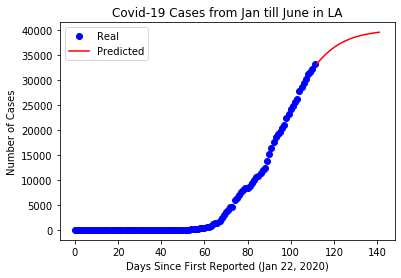

In [216]:
plot_predictions(la_timeseries_c, la_confirmed)
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.ylabel("Number of Cases")
plt.title("Covid-19 Cases from Jan till June in LA")
plt.legend();

The graph above illustrates the logistical model on the confirmed Covid-19 cases in LA. The prediction projects that the number of infected people is expected to rise, only approaching a plateau in mid-June. 

#### Predicting Deaths

In [217]:
la_timeseries_d = create_df(cal_timeseries1, 'Los Angeles')
la_timeseries_d

CountyName       Date  value        log  Days
18    Los Angeles 2020-01-22      0   0.000000     0
76    Los Angeles 2020-01-23      0   0.000000     1
134   Los Angeles 2020-01-24      0   0.000000     2
192   Los Angeles 2020-01-25      0   0.000000     3
250   Los Angeles 2020-01-26      1   0.693147     4
...           ...        ...    ...        ...   ...
6224  Los Angeles 2020-05-08  30319  10.319563   107
6282  Los Angeles 2020-05-09  31241  10.349519   108
6340  Los Angeles 2020-05-10  31703  10.364198   109
6398  Los Angeles 2020-05-11  32263  10.381707   110
6456  Los Angeles 2020-05-12  33211  10.410667   111

[112 rows x 5 columns]

In [218]:
la_deaths = predictions(la_timeseries_d)
la_deaths

array([33212.75795937, 33732.98413187, 34221.05128749, 34677.90446008,
       35104.62805048, 35502.41513966, 35872.53927495, 36216.32901633,
       36535.14538585, 36830.36224403, 37103.34952333, 37355.45917803,
       37588.01366034, 37802.29670107, 37999.54615644, 38180.94867812,
       38347.63596769, 38500.68238773, 38641.10371726, 38769.85685741,
       38887.84031253, 38995.89529243, 39094.80730022, 39185.30808939,
       39268.07789053, 39343.74782405, 39412.9024291 , 39476.0822516 ,
       39533.78644486, 39586.47534615])

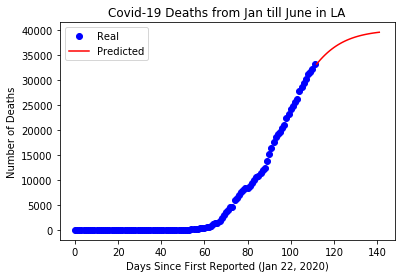

In [219]:
plot_predictions(la_timeseries_d, la_deaths)
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.ylabel("Number of Deaths")
plt.title("Covid-19 Deaths from Jan till June in LA")
plt.legend();

The logistic model seems to work well in counties classified as a high-risk zone. Similar to the logistic model for confirmed cases, the number of deaths due to Covid-19 is projected to increase, only starting to near a plateau in mid-June. Given that in the current environment, the number of infected people and deaths due to Covid-19 is expected to increase, it is recommended that the shelter in place order in high risk zones continue to be enforced for at least the next month. 

### Medium Risk Zone: San Diego

#### Predicting Confirmed Cases

In [220]:
sd_timeseries_c = create_df(cal_timeseries1, 'San Diego')
sd_timeseries_c

CountyName       Date  value       log  Days
36    San Diego 2020-01-22      0  0.000000     0
94    San Diego 2020-01-23      0  0.000000     1
152   San Diego 2020-01-24      0  0.000000     2
210   San Diego 2020-01-25      0  0.000000     3
268   San Diego 2020-01-26      0  0.000000     4
...         ...        ...    ...       ...   ...
6242  San Diego 2020-05-08   4429  8.396155   107
6300  San Diego 2020-05-09   4662  8.447414   108
6358  San Diego 2020-05-10   4776  8.471568   109
6416  San Diego 2020-05-11   5065  8.530307   110
6474  San Diego 2020-05-12   5161  8.549079   111

[112 rows x 5 columns]

In [221]:
sd_confirmed = predictions(sd_timeseries_c)
sd_confirmed

array([4955.21222963, 5036.19817642, 5113.37421711, 5186.77567087,
       5256.45720935, 5322.49045902, 5384.96163248, 5443.969232  ,
       5499.62185998, 5552.03616292, 5601.33492795, 5647.64534409,
       5691.09743466, 5731.82266208, 5769.95270231, 5805.61838298,
       5838.94877658, 5870.07043867, 5899.10677969, 5926.17755839,
       5951.39848477, 5974.8809205 , 5996.73166514, 6017.05281714,
       6035.94169933, 6053.49083927, 6069.78799578, 6084.91622387,
       6098.95397084, 6111.97519764])

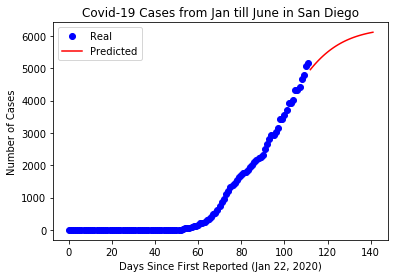

In [222]:
plot_predictions(sd_timeseries_c, sd_confirmed)
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.ylabel("Number of Cases")
plt.title("Covid-19 Cases from Jan till June in San Diego")
plt.legend();

The logistic model of Covid-19 cases of San Diego predicts that the infected people in Fresno is expected to rise in the following month, likely not pleateauing in the next month. 

####  Predicting Deaths

In [223]:
sd_timeseries_d = create_df(cal_timeseries2, 'San Diego')
sd_timeseries_d

CountyName       Date  value       log  Days
36    San Diego 2020-01-22      0  0.000000     0
94    San Diego 2020-01-23      0  0.000000     1
152   San Diego 2020-01-24      0  0.000000     2
210   San Diego 2020-01-25      0  0.000000     3
268   San Diego 2020-01-26      0  0.000000     4
...         ...        ...    ...       ...   ...
6242  San Diego 2020-05-08    165  5.111988   107
6300  San Diego 2020-05-09    169  5.135798   108
6358  San Diego 2020-05-10    175  5.170484   109
6416  San Diego 2020-05-11    175  5.170484   110
6474  San Diego 2020-05-12    190  5.252273   111

[112 rows x 5 columns]

In [224]:
sd_deaths = predictions(sd_timeseries_d)
sd_deaths

array([178.39477666, 180.70803368, 182.83555399, 184.7878287 ,
       186.57557703, 188.20955423, 189.70039322, 191.05847742,
       192.29384203, 193.41610019, 194.43439092, 195.35734528,
       196.1930678 , 196.94913037, 197.63257593, 198.24992985,
       198.80721713, 199.30998377, 199.76332098, 200.17189121,
       200.53995508, 200.87139859, 201.16975997, 201.43825593,
       201.67980691, 201.89706109, 202.09241723, 202.268046  ,
       202.42590998, 202.56778222])

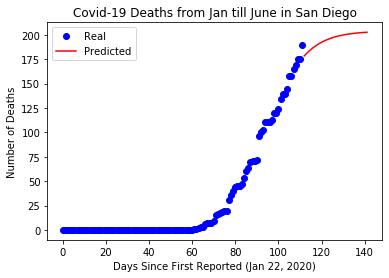

In [225]:
plot_predictions(sd_timeseries_d, sd_deaths)
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.ylabel("Number of Deaths")
plt.title("Covid-19 Deaths from Jan till June in San Diego")
plt.legend();

While this graph is somewhat disconnected, it is evident that the logistic pattern is still prevalent in the existing data points. The prediction is somewhat similar to that of LA in that the death rate will only approach a plateau by mid-June. It is for this reason that it is recommended that the shelter-in-place continue to be enforced for the next month. 

Furthermore, these graphs have illustrated that a logistic model can be applied to predict Covid-19 cases and related deaths in medium-risk counties. 

### Low-Risk Zone: Shasta

#### Predicting Confirmed Cases

In [226]:
sc_timeseries_c = create_df(cal_timeseries1, 'Shasta')
sc_timeseries_c

CountyName       Date  value       log  Days
44       Shasta 2020-01-22      0  0.000000     0
102      Shasta 2020-01-23      0  0.000000     1
160      Shasta 2020-01-24      0  0.000000     2
218      Shasta 2020-01-25      0  0.000000     3
276      Shasta 2020-01-26      0  0.000000     4
...         ...        ...    ...       ...   ...
6250     Shasta 2020-05-08     31  3.465736   107
6308     Shasta 2020-05-09     31  3.465736   108
6366     Shasta 2020-05-10     31  3.465736   109
6424     Shasta 2020-05-11     32  3.496508   110
6482     Shasta 2020-05-12     32  3.496508   111

[112 rows x 5 columns]

In [227]:
sc_confirmed = predictions(sc_timeseries_c)
sc_confirmed

array([29.97184704, 29.97302678, 29.97396881, 29.97472103, 29.97532166,
       29.97580125, 29.97618419, 29.97648996, 29.97673411, 29.97692905,
       29.9770847 , 29.97720898, 29.97730822, 29.97738745, 29.97745072,
       29.97750123, 29.97754157, 29.97757377, 29.97759949, 29.97762002,
       29.97763641, 29.9776495 , 29.97765995, 29.97766829, 29.97767496,
       29.97768028, 29.97768453, 29.97768792, 29.97769062, 29.97769279])

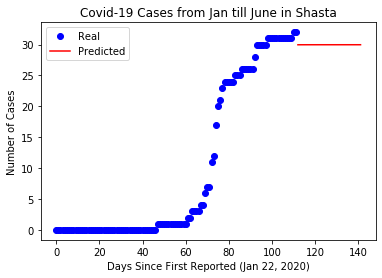

In [228]:
plot_predictions(sc_timeseries_c, sc_confirmed)
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.ylabel("Number of Cases")
plt.title("Covid-19 Cases from Jan till June in Shasta")
plt.legend();

The graph above is disconnected, piecewise function and as a result, the model is less likely to accurately reflect the predicted number of infected people; the predicted model calculated 29 people while the confirmed cases currently is 32. Even so, the data follows a logistical pattern. 

#### Predicting Deaths 

In [229]:
sc_timeseries_d = create_df(cal_timeseries2, 'Shasta')
sc_timeseries_d

CountyName       Date  value       log  Days
44       Shasta 2020-01-22      0  0.000000     0
102      Shasta 2020-01-23      0  0.000000     1
160      Shasta 2020-01-24      0  0.000000     2
218      Shasta 2020-01-25      0  0.000000     3
276      Shasta 2020-01-26      0  0.000000     4
...         ...        ...    ...       ...   ...
6250     Shasta 2020-05-08      4  1.609438   107
6308     Shasta 2020-05-09      4  1.609438   108
6366     Shasta 2020-05-10      4  1.609438   109
6424     Shasta 2020-05-11      4  1.609438   110
6482     Shasta 2020-05-12      4  1.609438   111

[112 rows x 5 columns]

In [230]:
sc_deaths = predictions(sc_timeseries_d)
sc_deaths

array([3.86905002, 3.8700368 , 3.8708716 , 3.87157777, 3.87217508,
       3.8726803 , 3.87310761, 3.873469  , 3.87377464, 3.87403312,
       3.87425171, 3.87443657, 3.87459289, 3.87472508, 3.87483686,
       3.87493139, 3.87501133, 3.87507892, 3.87513608, 3.87518441,
       3.87522528, 3.87525984, 3.87528906, 3.87531377, 3.87533466,
       3.87535233, 3.87536727, 3.8753799 , 3.87539059, 3.87539962])

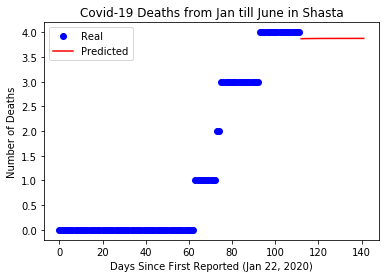

In [231]:
plot_predictions(sc_timeseries_d, sc_deaths)
plt.xlabel("Days Since First Reported (Jan 22, 2020)")
plt.ylabel("Number of Deaths")
plt.title("Covid-19 Deaths from Jan till June in Shasta")
plt.legend();

The current up-to-date data is very disjointed and as a result, it is more difficult for the logistic model to predict deaths. This is likely also due to low number of deaths that have occured in Shasta thus far, making it harder to model. However, even so, it is important to note that current data seems to follow a logistic model. Hence, it is likely that the logistic model is not suited for counties in low-risk zones.

Furthermore, given that the number of confirmed cases and deaths are not expected to increase, it is not necessary for the shelter-in-place in low-risk counties to be continued for the next month; however, given the possibility that individuals may migrate between low-risk and medium-risk and high-risk counties, it is a good idea to continue a modified shelter-in-place order. 

## Model Review 

Overall, a logistical model is best suited to provide accurate projections for coronavirus confirmed cases and deaths; however, testing the model on the three different risk zones, we found that the model works best for counties that can be classified as high-risk and medium-risk zones. 

A low-risk zone may have a low number of cases or deaths (due to smaller populations, less spread, or minimal data), thus it is difficult to build a logistical model and predict future cases. 

# Conclusion

In this notebook, we explored datasets related to Covid-19, focusing in on California counties in order to classify the counties into three risk zones and modeling the predicted number of confirmed cases and deaths in the next month. 

We were able to classify the counties into three different risk zones using five characteristics: Covid-19 Mortality rate, Covid-19 Incidence rate, ICU beds per person, Respiratory mortality, and Mortality of 25-44 year-olds. This aided in better understanding the virus' activity in counties in California. 

Once the counties were classified, we tested two different exponential and logistic models to better understand how to predict confirmed cases and deaths due to Covid-19. We found that a logistic model fit from a function is best suited to project coronavirus cases and deaths. 

The best found model, the logistical model function, was then applied on a county from each of the three identified risk zones to predict the number of infected individuals and deaths in order to assess the applicability of the logistic model on each of the three risk zones. 

It was found that the model was well-suited for high-risk zones and medium-risk zones; however, it was difficult to logistically model the spread of the virus and virus-related deaths in low-risk zones, likely due to smaller populations, inconsistent data points, or a lower number of infected individuals/deaths. 